In [149]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns # get more colormaps
plt.style.use("bioAI.mplstyle")
import torch
import scipy
import umap as umap
from ripser import ripser
from persim import plot_diagrams
import tqdm

import sys
sys.path.append('../')
from methods import *
from models import JacobianCI, JitterCI
from plotting_functions import set_size, project_cmap, minimal_ticks, scatter3d

import umap.umap_ as umap


In [204]:
#model1 = HexagonalGCs(ncells=100)
model1 = JacobianCI(ncells=100,lr=1e-3, shift=0, p_magnitude=0,seed=42)
model2 = HexagonalGCs(ncells=100)


model2.phases.data = 0.08*torch.randn(100,2)-torch.Tensor([0.05,0.05])
#deleted_phases = torch.logical_and(torch.logical_and(model2.phases[:,0]>-0.45,model2.phases[:,0]<0.45),
#                                   torch.logical_and(model2.phases[:,1]>-0.45,model2.phases[:,1]<0.45))
#model2.phases.data[deleted_phases,0] = -0.5
#model2.phases.data[deleted_phases,1] = 0

res = 100
rs = model1.unit_cell.mesh(res)

#train model 1 for optimal phases
nsamples_space = 2**8
for epoch in tqdm.trange(5000):
    r_samples = model1.unit_cell.sample(nsamples_space)
    r_samples = torch.tensor(r_samples,dtype=torch.float32)
    loss_CI = model1.train_step(r_samples)


J1 = model1.jacobian(torch.Tensor(rs))
g1 = model1.metric_tensor(J1).detach().numpy()
g1_det = model1.the_jacobian(J1).detach().numpy()

J2 = model2.jacobian(torch.Tensor(rs))
g2 = model1.metric_tensor(J2).detach().numpy()
g2_det = model2.the_jacobian(J2).detach().numpy()

activity1 = model1.forward(torch.Tensor(rs)).detach().numpy()
activity2 = model2.forward(torch.Tensor(rs)).detach().numpy()

projection1 = umap.UMAP(n_neighbors=40,min_dist=0.2,n_components=3)
projection2 = umap.UMAP(n_neighbors=40,min_dist=0.2,n_components=3)
proj1 = projection1.fit(activity1)
proj2 = projection2.fit(activity2)

model1_mfld = proj1.transform(activity1)
model2_mfld = proj2.transform(activity2)

n_steps = 50
step_size = 0.0125
r = np.zeros([n_steps,2])
r[-1,:] = [-0.35,-0.35]
xy_step  = [step_size,step_size]
for c,x in enumerate(np.random.choice([step_size,-step_size],size=(n_steps,2))):
    r[c,:] = r[c-1]+x+xy_step

traj_act1 = model1.forward(torch.Tensor(r)).detach().numpy()
traj_act2 = model2.forward(torch.Tensor(r)).detach().numpy()

traj_proj1 = proj1.transform(traj_act1)
traj_proj2 = proj2.transform(traj_act2)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:37<00:00, 134.42it/s]


[]

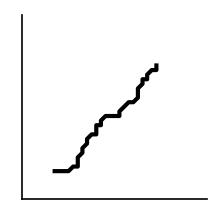

In [205]:
fig,ax = plt.subplots(1,1, sharex=True, sharey=True)
ax.plot(r[:,0],r[:,1],'k',linewidth=2)
ax.set_xlim(-0.5,0.5)
ax.set_ylim(-0.5,0.5)
ax.set_xticks([])
ax.set_yticks([])
#plt.savefig('traj.png',dpi=500)

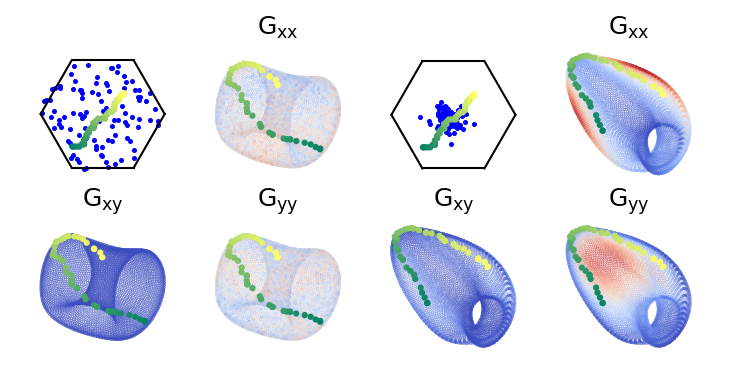

In [212]:
traj_cmap = 'summer'
g1_min, g1_max = np.min(g1[:,0,0]), np.max(g1[:,0,0])
g2_min, g2_max = np.min(g2[:,0,0]), np.max(g2[:,0,0])

figsize=set_size(fraction=(1,1/2),mode='square')
fig, axs = plt.subplots(2,4,figsize=figsize)
axs[0,0].scatter(*model1.phases.detach().numpy().T,s=2,color='blue')
model1.unit_cell.plot(fig,axs[0,0], color='black')
axs[0,0].scatter(*r.T,s=4,c=np.linspace(0,1,len(r)),cmap=traj_cmap)
axs[0,0].axis('off')
axs[0,0].axis('equal')
axs[0,1].scatter(*model1_mfld[:,:2].T,s=0.01,c=g1[:,0,0],cmap='coolwarm',vmin=g1_min,vmax=g1_max)
axs[0,1].scatter(*traj_proj1[:,:2].T,c=np.linspace(0,1,len(r)),cmap=traj_cmap,s=4)
axs[0,1].axis('off')
axs[0,1].set_title("$G_{xx}$")
axs[0,1].axis('equal')
axs[0,2].scatter(*model2.phases.detach().numpy().T,s=2,color='blue')
model2.unit_cell.plot(fig,axs[0,2],color='black')
axs[0,2].scatter(*r.T,c=np.linspace(0,1,len(r)),cmap=traj_cmap,s=4)
axs[0,2].axis('off')
axs[0,2].axis('equal')
axs[0,3].scatter(*model2_mfld[:,:2].T,s=0.01,c=g2[:,0,0],cmap='coolwarm',vmin=g2_min,vmax=g2_max)
axs[0,3].scatter(*traj_proj2[:,:2].T,c=np.linspace(0,1,len(r)),cmap=traj_cmap,s=4)
axs[0,3].axis('off')
axs[0,3].set_title("$G_{xx}$")
axs[0,3].axis('equal')
axs[1,0].scatter(*model1_mfld[:,:2].T,s=0.01,c=g1[:,1,0],cmap='coolwarm',vmin=g1_min,vmax=g1_max)
axs[1,0].scatter(*traj_proj1[:,:2].T,c=np.linspace(0,1,len(r)),cmap=traj_cmap,s=4)
axs[1,0].axis('off')
axs[1,0].set_title("$G_{xy}$")
axs[1,0].axis('equal')
axs[1,1].scatter(*model1_mfld[:,:2].T,s=0.01,c=g1[:,1,1],cmap='coolwarm',vmin=g1_min,vmax=g1_max)
axs[1,1].scatter(*traj_proj1[:,:2].T,c=np.linspace(0,1,len(r)),cmap=traj_cmap,s=4)
axs[1,1].axis('off')
axs[1,1].set_title("$G_{yy}$")
axs[1,1].axis('equal')
axs[1,2].scatter(*model2_mfld[:,:2].T,s=0.01,c=g2[:,1,0],cmap='coolwarm',vmin=g2_min,vmax=g2_max)
axs[1,2].scatter(*traj_proj2[:,:2].T,c=np.linspace(0,1,len(r)),cmap=traj_cmap,s=4)
axs[1,2].axis('off')
axs[1,2].set_title("$G_{xy}$")
axs[1,2].axis('equal')
axs[1,3].scatter(*model2_mfld[:,:2].T,s=0.01,c=g2[:,1,1],cmap='coolwarm',vmin=g2_min,vmax=g2_max)
axs[1,3].scatter(*traj_proj2[:,:2].T,c=np.linspace(0,1,len(r)),cmap=traj_cmap,s=4)
axs[1,3].axis('off')
axs[1,3].set_title("$G_{yy}$")
axs[1,3].axis('equal')
#plt.subplots_adjust(wspace=0.5, hspace=0.2)
fig.tight_layout(pad=0.35, w_pad=0, h_pad=0)
#plt.savefig('./F2-P2.png')

In [37]:
model = HexagonalGCs(ncells=1000)
activity = model.forward(torch.Tensor(rs)).detach().numpy()
J = model.jacobian(torch.Tensor(rs))
g_metric= model.metric_tensor(J).detach().numpy()
g_det = model.the_jacobian(J).detach().numpy()


In [38]:
g_xx = g_metric[:,0,0]
g_xy = g_metric[:,1,0]
g_yx = g_metric[:,0,1]
g_yy = g_metric[:,1,1]

projection = umap.UMAP(n_neighbors=25,n_components=3)
manifold = projection.fit_transform(activity)


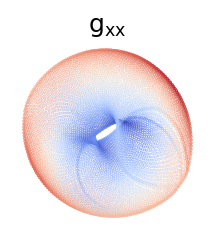

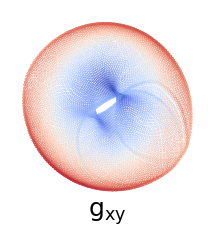

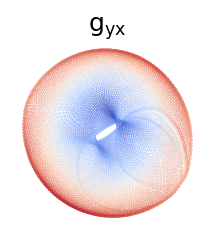

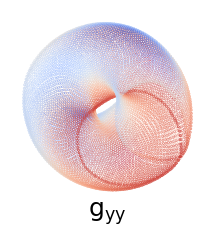

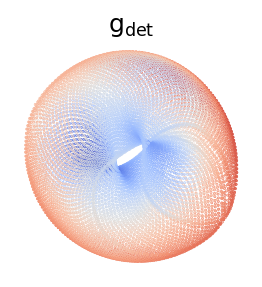

In [49]:
from matplotlib.gridspec import GridSpec

#fig = plt.figure(constrained_layout=True,figsize=(4,4))
#gs = GridSpec(10, 10, figure=fig,wspace=0.0, hspace=0.0,)

ax1 = plt.subplot(111)
ax1.scatter(*manifold[:,:2].T,s=0.02,c=g_xx,cmap='coolwarm')
ax1.set_title('$g_{xx}$')
ax1.axis('off')
plt.savefig('metric_tensor_xx.png',dpi=500,bbox_inches='tight')

plt.figure()
ax2 = plt.subplot(111)
ax2.scatter(*manifold[:,:2].T,s=0.02,c=g_xy,cmap='coolwarm')
ax2.set_title('$g_{xy}$', y=-0.15)
ax2.axis('off')
plt.savefig('metric_tensor_xy.png',dpi=500,bbox_inches='tight')

plt.figure()
ax3 = plt.subplot(111)
ax3.scatter(*manifold[:,:2].T,s=0.02,c=g_yx,cmap='coolwarm')
ax3.set_title('$g_{yx}$')
ax3.axis('off')
plt.savefig('metric_tensor_yx.png',dpi=500,bbox_inches='tight')

plt.figure()
ax4 = plt.subplot(111)
ax4.scatter(*manifold[:,:2].T,s=0.02,c=g_yy,cmap='coolwarm')
ax4.set_title('$g_{yy}$', y=-0.15)
ax4.axis('off')
plt.savefig('metric_tensor_yy.png',dpi=500,bbox_inches='tight')

plt.figure(figsize=(2,2))
ax5 = plt.subplot(111)
ax5.scatter(*manifold[:,:2].T,s=0.1,c=g_det,cmap='coolwarm')
ax5.set_title('$g_{det}$')
ax5.axis('off')
plt.savefig('metric_tensor_det.png',dpi=500,bbox_inches='tight')


